<a href="https://colab.research.google.com/github/pashakhomchenko/AlphaZero/blob/master/AlphaZero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this notebook is my follow along and exploration of this AlphaZero [tutorial](https://www.youtube.com/watch?v=wuSQpLinRB4). let's dive in

# Tic Tac Toe


## Game Setup

In [2]:
import numpy as np
import math

In [3]:
class TicTacToe:
  def __init__(self):
    self.row_count = 3
    self.column_count = 3
    self.action_size = self.row_count * self.column_count

  def get_initial_state(self):
    return np.zeros([self.row_count, self.column_count])

  def get_next_state(self, state, action, player):
    # action == 0 means top left corner, action == 9 - bottom right
    row = action // self.column_count
    column = action % self.column_count
    state[row, column] = player
    return state

  def get_valid_moves(self, state):
    # state.reshape(-1) - flattens the array
    return (state.reshape(-1) == 0).astype(np.uint8)

  def check_win(self, state, action):
    if action == None:
      return False

    row = action // self.column_count
    column = action % self.column_count
    player = state[row, column]
    return (
        np.sum(state[row, :]) == player * self.column_count
        or
        np.sum(state[:, column]) == player * self.row_count
        or
        np.sum(np.diag(state)) == player * self.row_count
        or
        # flipping the state to get the other diagonal
        np.sum(np.diag(np.flip(state))) == player * self.row_count
    )

  def get_value_and_terminated(self, state, action):
    if self.check_win(state, action):
      # win, reward is 1
      return 1, True
    if np.sum(self.get_valid_moves(state)) == 0:
      # draw, reward is 0
      return 0, True
    # continue the game
    return 0, False

  def get_opponent(self, player):
    return -player

  def get_opponent_value(self, value):
    return -value

  def change_perspective(self, state, player):
    return state * player

  def get_encoded_state(self, state):
    encoded_state = np.stack(
        (state == -1, state == 0, state == 1)
    ).astype(np.float32)
    return encoded_state

## Monte Carlo Tree Search

In [ ]:
class Node:
  def __init__(self, game, args, state, parent=None, action_taken=None):
    self.game = game
    self.args = args
    self.state = state
    self.parent = parent
    self.action_taken = action_taken

    self.children = []
    self.expandable_moves = game.get_valid_moves(state)

    self.visit_count = 0
    self.value_sum = 0

  def is_fully_expanded(self):
    # no moves and at least one child to select
    # if there are no moves and children, no child can be created - all options explored, cannot expand, continue selection
    # if there are no moves and no children, the game is over - is_terminated will be true, stop selection
    # if there are moves then we found a leaf node and can expand it, stop selection
    return np.sum(self.expandable_moves) == 0 and len(self.children) > 0

  def select(self):
    best_child = None
    best_ucb = -np.inf

    for child in self.children:
      ucb = self.get_ucb(child)
      if ucb > best_ucb:
        best_child = child
        best_ucb = ucb

    return best_child

  def get_ucb(self, child):
    # rescale to [0,1] range
    # Take inverse of q because the child is the opponent from perspective
    # of the parent, so we are looking for the worst q
    # (parent player 1, child player 2)
    q_value = 1 - (child.value_sum / child.visit_count + 1 ) / 2
    return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count) / child.visit_count)

  def expand(self):
    # select random move
    action = np.random.choice(np.where(self.expandable_moves == 1)[0])
    # no more expandable
    self.expandable_moves[action] = 0

    # create the new state that child will take
    child_state = self.state.copy()
    child_state = self.game.get_next_state(child_state, action, 1)
    child_state = self.game.change_perspective(child_state, -1)

    # create child
    child = Node(self.game, self.args, child_state, self, action)
    self.children.append(child)
    return child

  def simulate(self):
    value, is_terminated = self.game.get_value_and_terminated(self.state, self.action_taken)
    value = self.game.get_opponent_value(value)

    if is_terminated:
      return value

    # random playing until the game finishes
    rollout_state = self.state.copy()
    rollout_player = 1
    while True:
      valid_moves = self.game.get_valid_moves(rollout_state)
      action = np.random.choice(np.where(valid_moves == 1)[0])
      rollout_state = self.game.get_next_state(rollout_state, action, rollout_player)
      value, is_terminated = self.game.get_value_and_terminated(rollout_state, action)
      if is_terminated:
        if rollout_player == -1:
          value = self.game.get_opponent_value(value)
        return value

      rollout_player = self.game.get_opponent(rollout_player)

  def backpropogate(self, value):
    # update yourself
    self.value_sum += value
    self.visit_count += 1

    # update parent
    value = self.game.get_opponent_value(value)
    if self.parent is not None:
      self.parent.backpropogate(value)


class MCTS:
  def __init__(self, game, args):
    self.game = game
    self.args = args

  def search(self, state):
    root = Node(self.game, self.args, state)

    for search in range(self.args['num_searches']):
      node = root

      # Selection
      while node.is_fully_expanded():
        node = node.select()

      value, is_terminated = self.game.get_value_and_terminated(node.state, node.action_taken)
      # value above is value of the opponent
      value = self.game.get_opponent_value(value)

      if not is_terminated:
        # Expansion
        node = node.expand()
        # Simulation
        value = node.simulate()

      # Backpropogation
      node.backpropogate(value)

    action_probs = np.zeros(self.game.action_size)
    for child in root.children:
      action_probs[child.action_taken] = child.visit_count
    action_probs /= np.sum(action_probs)
    return action_probs



## Game with MCTS

In [ ]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 1.41,
    'num_searches': 1000
}
mcts = MCTS(tictactoe, args)

state = tictactoe.get_initial_state()

while True:
  print(state)

  if player == 1:
    valid_moves = tictactoe.get_valid_moves(state)
    print("valid moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
    action = int(input(f"{player}:"))

    if valid_moves[action] == 0:
      print("action not valid")
      continue
  else:
    neutral_state = tictactoe.change_perspective(state, player)
    mcts_probs = mcts.search(neutral_state)
    action = np.argmax(mcts_probs)

  state = tictactoe.get_next_state(state, action, player)
  value, is_terminated = tictactoe.get_value_and_terminated(state, action)

  if is_terminated:
    print(state)
    if value == 1:
      print(player, "won")
    else:
      print("draw")
    break

  # switch to the next player
  player = tictactoe.get_opponent(player)

too easy

##AlphaMCTS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

In [4]:
from torch.nn.modules.activation import Softmax
class ResNet(nn.Module):
  def __init__(self, game, num_resBlocks, num_hidden):
    super().__init__()
    self.startBlock = nn.Sequential(
        nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
        nn.BatchNorm2d(num_hidden),
        nn.ReLU()
    )
    self.backBone = nn.ModuleList(
        [ResBlock(num_hidden) for i in range(num_resBlocks)]
    )
    self.policyHead = nn.Sequential(
        nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32 * game.row_count * game.column_count, game.action_size), # policy output
        # why not add softmax in here??
    )
    self.valueHead = nn.Sequential(
        nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
        nn.BatchNorm2d(3),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3 * game.row_count * game.column_count, 1), # value output
        nn.Tanh()
    )

  def forward(self, x):
    x = self.startBlock(x)
    for resBlock in self.backBone:
      x = resBlock(x)
    policy = self.policyHead(x)
    value = self.valueHead(x)
    return policy, value

class ResBlock(nn.Module):
  def __init__(self, num_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(num_hidden)
    self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(num_hidden)

  def forward(self, x):
    residual = x
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.bn2(self.conv2(x))
    x += residual # skip connection, allows to mask out conv
    x = F.relu(x)
    return x


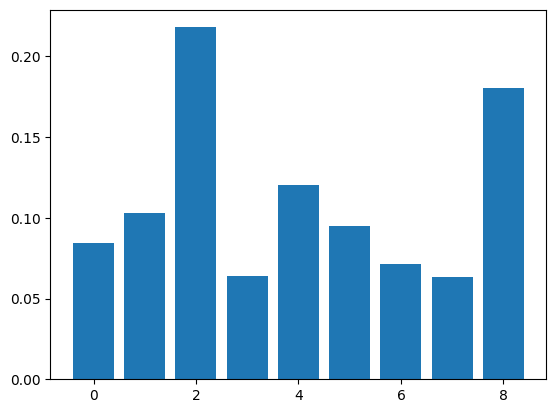

In [ ]:
import matplotlib.pyplot as plt

tictactoe = TicTacToe()

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

encoded_state = tictactoe.get_encoded_state(state) # 3 planes

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(tictactoe, 4, 64)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [5]:
class AlphaNode:
  def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
    self.game = game
    self.args = args
    self.state = state
    self.parent = parent
    self.action_taken = action_taken
    self.prior = prior # prob that is given by parent to this node

    self.children = []

    self.visit_count = 0
    self.value_sum = 0

  def is_fully_expanded(self):
    # now we exapnd in all direction immediately as we have policy
    return len(self.children) > 0

  def select(self):
    best_child = None
    best_ucb = -np.inf

    for child in self.children:
      ucb = self.get_ucb(child)
      if ucb > best_ucb:
        best_child = child
        best_ucb = ucb

    return best_child

  def get_ucb(self, child):
    # rescale to [0,1] range
    # Take inverse of q because the child is the opponent from perspective
    # of the parent, so we are looking for the worst q
    # (parent player 1, child player 2)
    if child.visit_count == 0:
      q_value = 0
    else:
      q_value = 1 - (child.value_sum / child.visit_count + 1 ) / 2
    return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

  def expand(self, policy):
    for action, prob in enumerate(policy):
      if prob > 0:
        # create the new state that child will take
        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, 1)
        child_state = self.game.change_perspective(child_state, -1)

        # create child
        child = AlphaNode(self.game, self.args, child_state, self, action, prob)
        self.children.append(child)

  def backpropogate(self, value):
    # update yourself
    self.value_sum += value
    self.visit_count += 1

    # update parent
    value = self.game.get_opponent_value(value)
    if self.parent is not None:
      self.parent.backpropogate(value)

class AlphaMCTS:
  def __init__(self, game, args, model):
    self.game = game
    self.args = args
    self.model = model

  @torch.no_grad()
  def search(self, state):
    root = AlphaNode(self.game, self.args, state)

    for search in range(self.args['num_searches']):
      node = root

      # Selection
      while node.is_fully_expanded():
        node = node.select()

      value, is_terminated = self.game.get_value_and_terminated(node.state, node.action_taken)
      # value above is value of the opponent
      value = self.game.get_opponent_value(value)

      if not is_terminated:
        policy, value = self.model(
            # batch dim, as we don't have batches, it's just a singleton dim
            torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy() # get rid of batch dim

        # mask out illiegal moves
        valid_moves = self.game.get_valid_moves(node.state)
        policy *= valid_moves
        policy /= np.sum(policy)

        value = value.item()

        # Expansion
        node.expand(policy)

        # Simulation - no longer needed
        # value = node.simulate()

      # Backpropogation
      node.backpropogate(value)

    action_probs = np.zeros(self.game.action_size)
    for child in root.children:
      action_probs[child.action_taken] = child.visit_count
    action_probs /= np.sum(action_probs)
    return action_probs

In [ ]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}
model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = AlphaMCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True:
  print(state)

  if player == 1:
    valid_moves = tictactoe.get_valid_moves(state)
    print("valid moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
    action = int(input(f"{player}:"))

    if valid_moves[action] == 0:
      print("action not valid")
      continue
  else:
    neutral_state = tictactoe.change_perspective(state, player)
    mcts_probs = mcts.search(neutral_state)
    action = np.argmax(mcts_probs)

  state = tictactoe.get_next_state(state, action, player)
  value, is_terminated = tictactoe.get_value_and_terminated(state, action)

  if is_terminated:
    print(state)
    if value == 1:
      print(player, "won")
    else:
      print("draw")
    break

  # switch to the next player
  player = tictactoe.get_opponent(player)

##AlphaZero

In [11]:
class AlphaZero:
  def __init__(self, model, optimizer, game, args):
    self.model = model
    self.optimizer = optimizer
    self.game = game
    self.args = args
    self.mcts = AlphaMCTS(game, args, model)

  def selfPlay(self):
    memory = [] # training data for the model for a single game
    player = 1
    state = self.game.get_initial_state()

    while True:
      neutral_state = self.game.change_perspective(state, player)
      action_probs = self.mcts.search(neutral_state)

      memory.append((neutral_state, action_probs, player))
      action = np.random.choice(self.game.action_size, p=action_probs)
      state = self.game.get_next_state(state, action, player)

      value, is_terminated = self.game.get_value_and_terminated(state, action)

      if is_terminated:
        returnMemory = []
        for hist_neutral_state, hist_action_probs, hist_player in memory:
          hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
          returnMemory.append((self.game.get_encoded_state(hist_neutral_state),
                           hist_action_probs,
                           hist_outcome))
          return returnMemory

      player = self.game.get_opponent(player)

  def train(self, memory):
    pass

  def learn(self):
    for iteration in range(self.args['num_iterations']):
      memory = [] # training data for the model

      self.model.eval()
      for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
        memory += self.selfPlay()

      self.model.train()
      for epoch in trange(self.args['num_epochs']):
        self.train(memory)

      torch.save(self.model.state_dict(), f"model_{iteration}.pt")
      torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [12]:
tictactoe = TicTacToe()

model = ResNet(tictactoe, 4, 64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored